In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Import libraries

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats

import my_functions as func

In [4]:
"""
Main program

"""

# Initiate a dictionary with characteristics and layout information
char_dict = func.make_char_dict()

## Cylindricity of convex cylinders

<AxesSubplot:xlabel='angle', ylabel='error'>

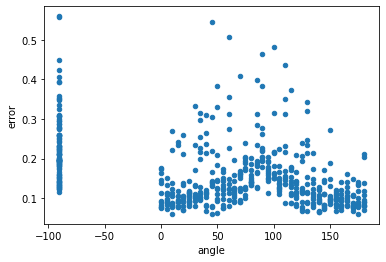

In [5]:
# List of characteristics to plot
chars = ['Cylindricity_Cyl_4mm_Pos',\
         'Cylindricity_Cyl_8mm_Pos',\
         'Cylindricity_Cyl_16mm_Pos',\
         'Cylindricity_Cyl_24mm_Pos']

# Retrieve the characteristics from the dictionary
dfs = pd.concat(char_dict[chars[i]] for i in range(len(chars)))

dfs.plot.scatter(x='angle', y='error')

<AxesSubplot:xlabel='angle', ylabel='error'>

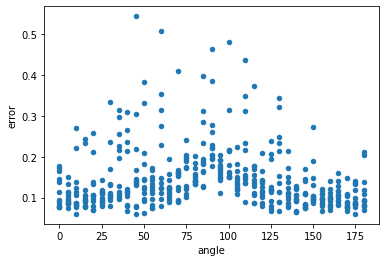

In [6]:
# Remove anchors from dataset
df1 = dfs[dfs['angle'] != -90]

df1.plot.scatter(x='angle', y='error')

<AxesSubplot:xlabel='s_angle', ylabel='error'>

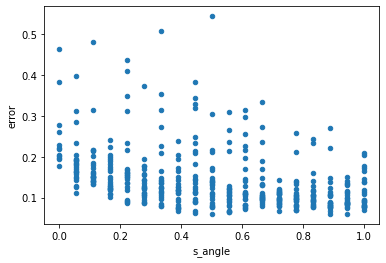

In [7]:
# Construct s_angle where 0 represents horizontal and 1 vertical orientation

df1.insert(7, 's_angle', abs(df1['angle']-90) / 90)

df1.plot.scatter(x='s_angle', y='error')

<AxesSubplot:xlabel='s_angle', ylabel='error'>

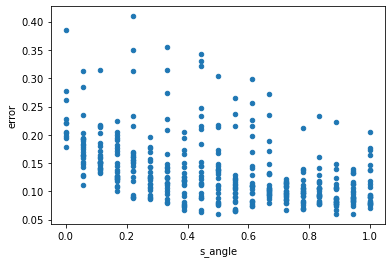

In [8]:
"""
Filter results by quantiles

"""

df_ang = df1

for ang in df_ang['s_angle'].unique():
    q_hi = df_ang[(df_ang['s_angle'] == ang)]['error'].quantile(0.99)
    
    if ang == df_ang['s_angle'].unique()[0]:
        df_filtered = df_ang[(df_ang['s_angle'] == ang) & (df_ang['error'] < q_hi)]
    else:
        df_filtered = pd.concat([df_filtered, df_ang[(df_ang['s_angle'] == ang) & (df_ang['error'] < q_hi)]])
    
df_filtered.plot.scatter(x='s_angle', y='error')

<AxesSubplot:xlabel='s_angle', ylabel='error'>

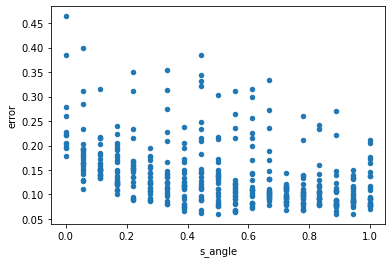

In [9]:
"""
Filtering results by standard deviations

"""

# Copy dataframe
df_new = df1

std = df_new['error'].std()


for ang in df_new['s_angle'].unique():
    hi_lim = df_new[(df_new['s_angle'] == ang)]['error'].mean() + (3*std)    
    
    if ang == df_new['s_angle'].unique()[0]:
        df_filtered = df_new[(df_new['s_angle'] == ang) & (df_new['error'] < hi_lim)]
    else:
        df_filtered = pd.concat([df_filtered, df_new[(df_new['s_angle'] == ang) & (df_new['error'] < hi_lim)]])
    
df_filtered.plot.scatter(x='s_angle', y='error')

## Cylindricity of concave cylinders

<AxesSubplot:xlabel='angle', ylabel='error'>

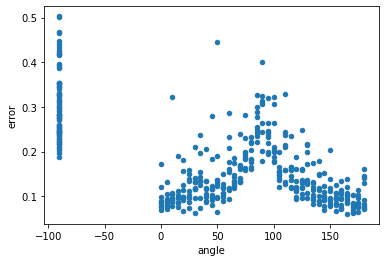

In [10]:
# List of characteristics to plot
chars = ['Cylindricity_Cyl_8mm_Neg',\
         'Cylindricity_Cyl_16mm-Neg',\
         'Cylindricity_Cyl_24mm_Neg']

# Retrieve the characteristics from the dictionary
dfs = pd.concat(char_dict[chars[i]] for i in range(len(chars)))

dfs.plot.scatter(x='angle', y='error')

<AxesSubplot:xlabel='angle', ylabel='error'>

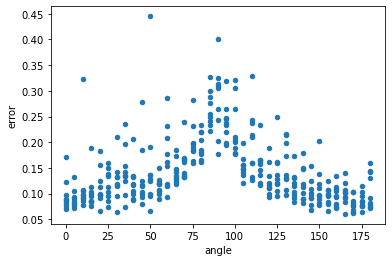

In [11]:
# Remove anchors from dataset
df1 = dfs[dfs['angle'] != -90]

df1.plot.scatter(x='angle', y='error')

<AxesSubplot:xlabel='s_angle', ylabel='error'>

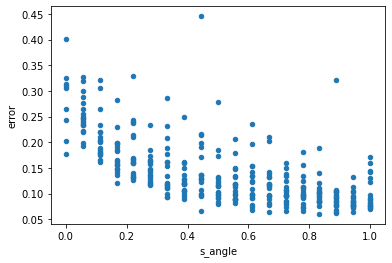

In [12]:
# Construct s_angle where 0 represents horizontal and 1 vertical orientation
df1.insert(7, 's_angle', abs(df1['angle']-90) / 90)

df1.plot.scatter(x='s_angle', y='error')

<AxesSubplot:xlabel='s_angle', ylabel='error'>

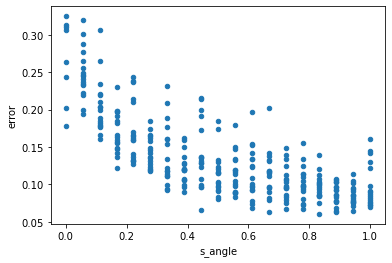

In [13]:
"""
Filter results by quantiles

"""

df_ang = df1

for ang in df_ang['s_angle'].unique():
    q_hi = df_ang[(df_ang['s_angle'] == ang)]['error'].quantile(0.99)
    
    if ang == df_ang['s_angle'].unique()[0]:
        df_filtered = df_ang[(df_ang['s_angle'] == ang) & (df_ang['error'] < q_hi)]
    else:
        df_filtered = pd.concat([df_filtered, df_ang[(df_ang['s_angle'] == ang) & (df_ang['error'] < q_hi)]])
    
df_filtered.plot.scatter(x='s_angle', y='error')

<AxesSubplot:xlabel='s_angle', ylabel='error'>

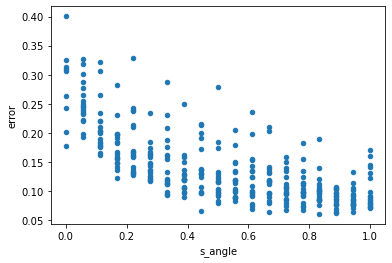

In [14]:
"""
Filtering results by standard deviations

"""

# Copy dataframe
df_new = df1

std = df_new['error'].std()


for ang in df_new['s_angle'].unique():
    hi_lim = df_new[(df_new['s_angle'] == ang)]['error'].mean() + (3*std)
    lo_lim = df_new[(df_new['s_angle'] == ang)]['error'].mean() - (3*std)
    
    if ang == df_new['s_angle'].unique()[0]:
        df_filtered = df_new[(df_new['s_angle'] == ang) & (df_new['error'] < hi_lim) & (df_new['error'] > lo_lim)]
    else:
        df_filtered = pd.concat([df_filtered, df_new[(df_new['s_angle'] == ang) & (df_new['error'] < hi_lim) & (df_new['error'] > lo_lim)]])
    
df_filtered.plot.scatter(x='s_angle', y='error')

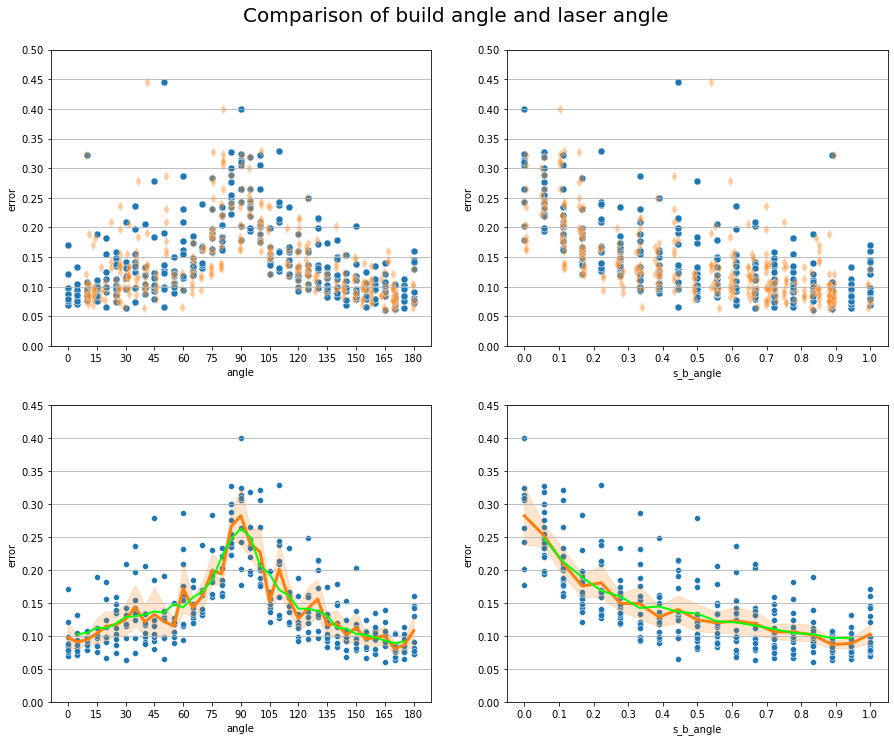

In [15]:
"""
Investigate the effect of laser angle and the symetry about 90 degrees orientation

Missing:
 - Axis labels
 - Axis titles
 - Plot titles
 - Plot legend
 - Edit figure title

"""


## Prepare data
# List of characteristics
chars = ['Cylindricity_Cyl_8mm_Neg',\
         'Cylindricity_Cyl_16mm-Neg',\
         'Cylindricity_Cyl_24mm_Neg']

# Retrieve the characteristics from the dictionary
dfs = pd.concat(char_dict[chars[i]] for i in range(len(chars)))

# Remove anchors from dataset
dfs = dfs[dfs['angle'] != -90]

# Add column for laser angle
dfs = func.add_laser_angle(dfs)

# Add scaled angles for build angle
dfs.insert(7, 's_b_angle', abs(dfs['angle']-90) / 90)

# Add scaled angles for laser angle
dfs.insert(7, 's_l_angle', abs(dfs['laser_angle']-90) / 90)


## Create figure
# Initialize figure as a grid of plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Set figure title
fig.suptitle('Comparison of build angle and laser angle', y=0.93, fontsize=20)

# Define colors
colors = ['tab:blue', 'tab:orange']

# Define symbols
symbol = 'd'

# Define transperancy
transp = 0.4

# Define legend elements
legend_elements = [Patch(facecolor=colors[0], label='Build angle'),\
                   Patch(facecolor=colors[1], label='Laser angle')]

## Plot unfiltered data in first row of the figure
# Set ticks along the x-axis
axs[0, 0].set_xticks(np.arange(0, 181, 15))
axs[0, 1].set_xticks(np.linspace(0, 1, 11))

# Control the scope of the y-axis
axs[0, 0].set_ylim(0, 0.5)
axs[0, 1].set_ylim(0, 0.5)

# Set ticks along the y-axis
axs[0, 0].set_yticks(np.linspace(0, 0.5, 11))
axs[0, 1].set_yticks(np.linspace(0, 0.5, 11))

# Add horizontal lines at the ticks
axs[0, 0].grid(axis='y')
axs[0, 1].grid(axis='y')

# Plot the unfiltered data
sns.scatterplot(ax=axs[0, 0], data=dfs, x='angle', y='error', s=50)
sns.scatterplot(ax=axs[0, 0], data=dfs, x='laser_angle', y='error', marker=symbol, s=50, alpha=transp)
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_b_angle', y='error', s=50)
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_l_angle', y='error', marker=symbol, s=50, alpha=transp)


## Filter results by standard deviation
# Calculate the standard deviation for the entire population
std = dfs['error'].std()

# Go thorugh all the unique angles
for ang in dfs['s_b_angle'].unique():
    # Calculate upper and lower limits as +/- 3 standard deviations
    hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() + (3*std)
    lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() - (3*std)
    
    # Filter out values
    if ang == dfs['s_b_angle'].unique()[0]:
        df_filtered = dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]
    else:
        df_filtered = pd.concat([df_filtered, dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]])
        
        
## Plot filtered data in second row of the figure
# Set ticks along the x-axis
axs[1, 0].set_xticks(np.arange(0, 181, 15))
axs[1, 1].set_xticks(np.linspace(0, 1, 11))

# Control the scope of the y-axis
axs[1, 0].set_ylim(0, 0.45)
axs[1, 1].set_ylim(0, 0.45)

# Set ticks along the y-axis
axs[1, 0].set_yticks(np.linspace(0, 0.45, 10))
axs[1, 1].set_yticks(np.linspace(0, 0.45, 10))

# Add horizontal lines at the ticks
axs[1, 0].grid(axis='y')
axs[1, 1].grid(axis='y')

# Plot the filtered data
sns.scatterplot(ax=axs[1, 0], data=df_filtered, x='angle', y='error')
sns.scatterplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error')
sns.lineplot(ax=axs[1, 0], data=df_filtered, x='angle', y='error', color='tab:orange', linewidth=3)
sns.lineplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color='tab:orange', linewidth=3)


## Calculate mean values
# Create dataframe with mean error values for each angle
m_df = dfs[['error', 'angle']].groupby('angle').mean().reset_index()

# Compute the rolling mean for each angle +/- 1
m_df['rolling'] = m_df['error'].rolling(3).mean().shift(-1)

# Create dataframe with mean error values for each scaled angle
m_s_df = dfs[['error', 's_b_angle']].groupby('s_b_angle').mean().reset_index()

# Compute the rolling mean for each scaled angle +/- 1
m_s_df['rolling'] = m_s_df['error'].rolling(3).mean().shift(-1)

# Plot rolling mean values to second row of the figure
sns.lineplot(ax=axs[1, 0], data=m_df, x='angle', y='rolling', color='lime', linewidth=2)
sns.lineplot(ax=axs[1, 1], data=m_s_df, x='s_b_angle', y='rolling', color='lime', linewidth=2)


## Display plot
plt.show()